# Задание

Анализ изображений классическими методами компьютерного зрения:

1) 
2) Найти полосы движения на изображении `./images/road1.png` и точку схода этих прямых. 
3) По изображению `./images/src_ball.jpg` получить “вид сверху”, найти шары и кий, оценить направление удара и траекторию прицельного шара после удара.

# Настройки/Импорты

In [1]:
import cv2 # для работы с изображениями
import numpy as np # для работы с массивами
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

# Вспомогательные функции

In [2]:
def show_image(image, figsize: tuple, gray: bool=False) -> None:
    """
    Функция для вывода изображений.\n
    Parameters:
        * image: изображение, что нужно вывести
        * figsize: размер выводимой картинки
        * gray: флаг, является ли изображение одноканальным (чёрно-белым)\n
    Returns:
        * None
    """
    cmap = "gray" if gray else "viridis" # выбор цветовой схемы, (стандартная — "viridis", но если передан ключ gray — "gray")

    plt.figure(figsize=figsize) # размер фигуры
    plt.imshow(image, cmap) # вывод изображения
    plt.show() # показ фигуры

In [167]:
def find_intersection(line1: list, line2: list) -> np.array:
    """Функция для поиска точки пересечения прямых.\n
    Parameters:
        * line1: первая прямая, заданная двумя точками в формате [x1, y1, x2, y2] 
        * line2: вторая прямая, заданная двумя точками в формате [x3, y3, x4, y4]\n
    Returns:
        * np.array: целые координата точки пересечения в формате [x, y]
    """
    x1, y1, x2, y2 = line1 # берём координаты точек на первой прямой
    x3, y3, x4, y4 = line2 # берём координаты точек на второй прямой
    px= ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) # считаем точку пересечения по x
    py= ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) # считаем точку пересечения по y
    return np.array([px, py], dtype=np.int32) # возвращаем целые координаты точки пересечения

# 1)

# 2) Найти полосы движения на изображении `./images/road1.png` и точку схода этих прямых. 

## Загрузка изображения

In [60]:
img_bgr = cv2.imread('./images/road1.png') # загружаем изображение
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # конвертируем в другую цветовую схему (изначально картинка в формате BGR)
img_rgb.shape # размерность изображения (height, width, colors)

(590, 1178, 3)

Original shape: (590, 1178, 3)


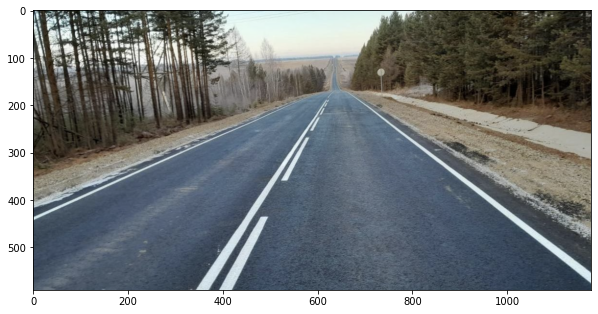

In [61]:
print(f"Original shape: {img_rgb.shape}") # вывод размерности
show_image(image=img_rgb, figsize=(10, 20)) # вывод изображения

## Преобразования над изображением

Конвертируем изображение в чёрно-белый формат, так как в нём находятся более чёткие линии.

Grayscale shape: (590, 1178)


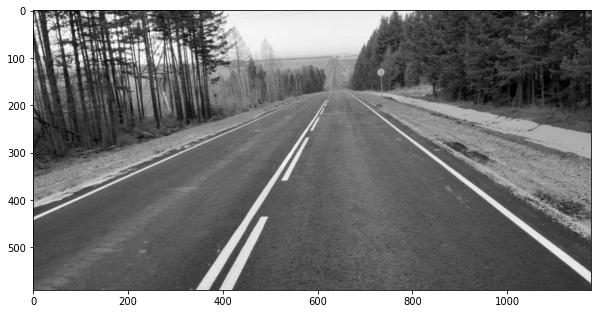

In [62]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) # конвертируем из RGB в чёрно-белую цветовую схему (cv2.COLOR_RGB2GRAY)
print(f"Grayscale shape: {img_gray.shape}") # вывод размерности
show_image(image=img_gray, figsize=(10, 20), gray=True) # вывод изображения

Добавляем размытие чтобы сгладить нечёткие места => градиенты уменьшаться => будет найдено меньше линий в алгоритме Кэнни (нахождения границ объектов на изображении).

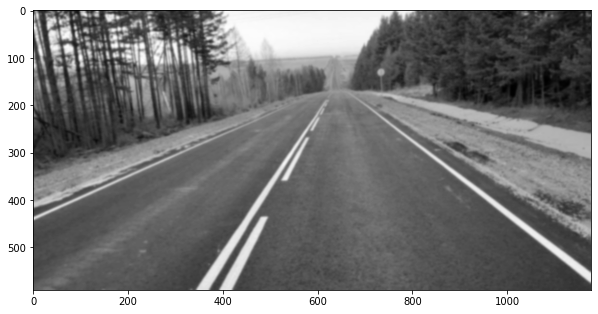

In [91]:
img_gray_blur = cv2.GaussianBlur(img_gray, ksize=(9, 9), sigmaX=0) # добавляем размытие на изображение (ksize — размер ядра в пикселях, sigmaX — стандартное отклонение для ядра Гаусса (дублируется в sigmaY))
show_image(image=img_gray_blur, figsize=(10, 20), gray=True) # вывод изображения

## Поиск основной полосы движения

Ищем границы объектов.

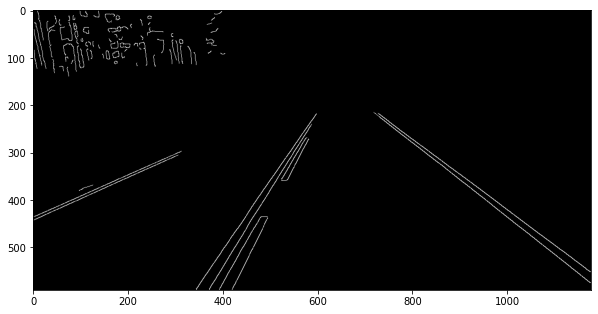

In [92]:
edges_gray_blur = cv2.Canny(img_gray_blur, threshold1=200, threshold2=300) # запускаем алгоритм Кэнни поиска границ объектов (threshold1 и threshold2 — пороги для алгоритма)
show_image(image=edges_gray_blur, figsize=(10, 20), gray=True) # вывод изображения

Пример того, что бы было на обычном RGB изображении, без проведённых преобразований (чёрно-белая картинка + блюр).

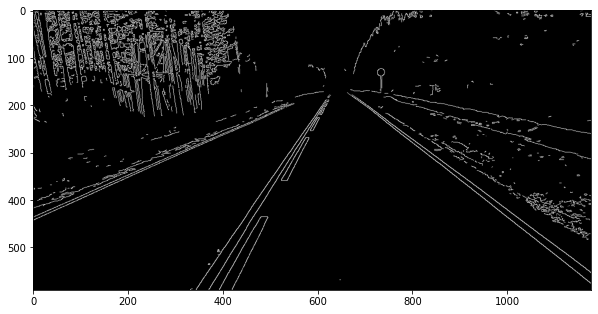

In [90]:
edges_rgb = cv2.Canny(img_rgb, threshold1=200, threshold2=300) # запускаем алгоритм Кэнни поиска границ объектов (threshold1 и threshold2 — пороги для алгоритма)
show_image(image=edges_rgb, figsize=(10, 20), gray=True) # вывод изображения

Находим линии с помощью вероятностного преобразования Хафа (из каждой точки изображения создаются гипотезы о существовании линии, принимаются же те, что смогли набрать определённое число голосов ~ совпали с такими же гипотезами, но из других точек изображения).

In [170]:
lines = cv2.HoughLinesP(image=edges_gray_blur, rho=1, theta=np.pi/180, threshold=250, minLineLength=320, maxLineGap=150) # поиск линий преобразованием Хафа
# image — одноканальное БИНАРНОЕ изображение (только два цвета — чёрный и белый)
# rho — разрешение сетки Хафа в пикселях (шаг в пикселях ~ изменение длины линий у гипотез) (distance resolution in pixels of the Hough grid)
# theta — угловое разрешение в радианах для сетки Хафа (на какой угол будут различаться гипотезы) (angular resolution in radians of the Hough grid)
# threshold — минимальное количество голосов для линии, чтобы она таковой считалась (сколько гипотез должно совпасть для линии)
# minLineLength — минимальное число пикселей в линии
# maxLineGap — максимальное число пикселей, что могут разделять одну линию

lines = lines.reshape(lines.shape[0], lines.shape[-1]) # убираем лишнюю вложенность
lines # найденные линии (параметры подобраны специально, чтобы нашлось только две линии) 
# в формате (ширина точки 1, высота точки 1, ширина точки 2, высота точки 2) однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([[ 719,  215, 1133,  539],
       [ 376,  579,  587,  241]], dtype=int32)

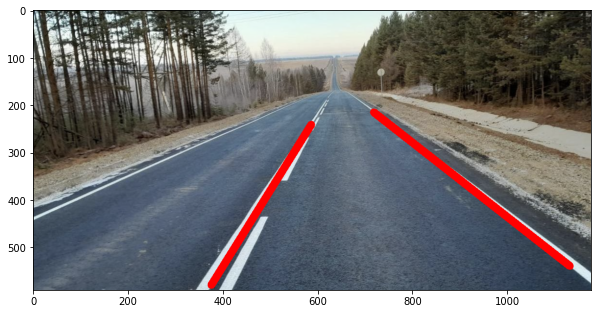

In [171]:
img_res = img_rgb.copy() # делаем копию, чтобы не испортить оригинал
for i in range(lines.shape[0]): # идём по числу найденных линий
    img_res = cv2.line(img=img_res, pt1=lines[i][:2], pt2=lines[i][2:4], color=(255,0,0), thickness=15) # добавляем линию на изображение 
    # img — изображение, на которое добавятся линии (будет перезаписано)
    # pt1 и pt2 — координаты начала и конца линии
    # color — цвет линии
    # thickness — толщина линии
show_image(image=img_res, figsize=(10, 20)) # вывод изображения

## Нахождение [точки пересечения](https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection)

In [172]:
intersection_point = find_intersection(lines[0], lines[1]) # считаем координаты точки пересечения двух прямых
intersection_point # сначала идёт ширина, а потом высота; однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([641, 154])

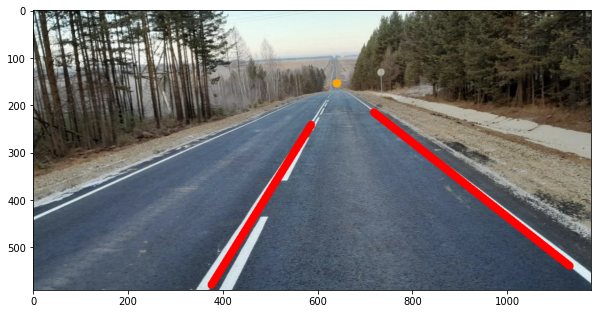

In [173]:
img_res = cv2.circle(img=img_res, center=intersection_point, radius=1, color=(255,165,0), thickness=15) # добавляем точку на изображение
# img — изображение, на которое добавится круг (будет перезаписано)
# center — координаты центра добавляемой окружности
# radius — радиус окружности в пикселях
# color — цвет окружности
# thickness — ширина линии окружности

show_image(image=img_res, figsize=(10, 20)) # вывод изображения

# 3) По изображению `./images/src_ball.jpg` получить “вид сверху”, найти шары и кий, оценить направление удара и траекторию прицельного шара после удара.  

## Загрузка изображения

In [3]:
img_bgr = cv2.imread('./images/src_balls.jpg') # загружаем изображение
img_bgr.shape # размерность изображения (height, width, colors)

(4032, 3024, 3)

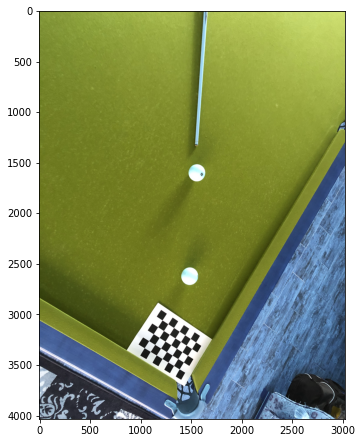

In [4]:
show_image(image=img_bgr, figsize=(10, 7.5)) # вывод изображения

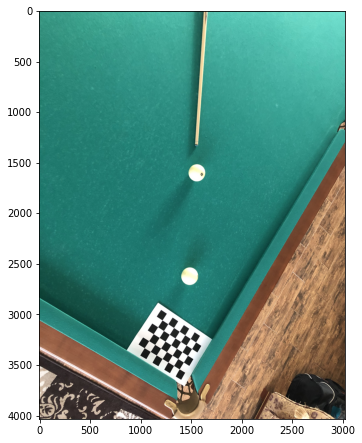

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # конвертируем в другую цветовую схему (изначально картинка в формате BGR)
show_image(image=img_rgb, figsize=(10, 7.5)) # вывод изображения

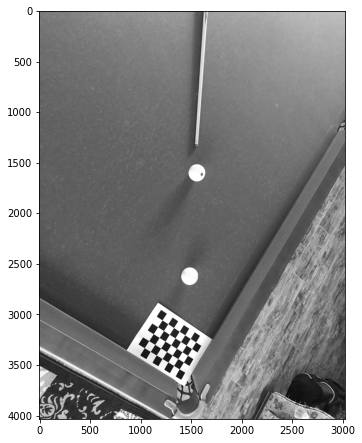

In [6]:
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) # конвертируем в другую цветовую схему (изначально картинка в формате BGR)
show_image(image=img_gray, figsize=(10, 7.5), gray=True) # вывод изображения

## Нахождение шахматной сетки

In [7]:
ret, corners = cv2.findChessboardCorners(image=img_rgb, patternSize=(7,5), corners=None) # ищем углы шахматной доски (на чёрно-белом изображении)
# image — 8-bit grayscale или цветное изображение
# patternSize — количество внутренних углов у шахматной доски (за строку, за столбец) ~ (число строк доски -1, число столбцов доски -1)
# corners — выходной массив для обнаруженных углов (None, чтобы вернуть их как результат выполнения функции)

In [8]:
# вывод результата работы функции "findChessboardCorners" (найдена ли доска, координат внутренних углов у доски)
print(f"Найдена ли шахматная доска: {ret}.")
corners # np.array внутренних углов (координаты углов: сначала идёт ширина, а потом высота; однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!))

Найдена ли шахматная доска: True.


array([[[1219.4376, 3056.5808]],

       [[1277.0518, 3094.7585]],

       [[1333.8605, 3132.0178]],

       [[1390.2826, 3169.0957]],

       [[1444.555 , 3205.57  ]],

       [[1499.2079, 3239.8086]],

       [[1552.0151, 3275.3193]],

       [[1175.9465, 3125.195 ]],

       [[1234.6776, 3162.3206]],

       [[1291.4543, 3199.15  ]],

       [[1348.2926, 3235.7307]],

       [[1402.5997, 3270.6343]],

       [[1457.9357, 3306.1316]],

       [[1511.2125, 3340.624 ]],

       [[1131.752 , 3192.421 ]],

       [[1190.5787, 3230.497 ]],

       [[1249.0702, 3266.6582]],

       [[1305.579 , 3302.8232]],

       [[1362.2975, 3337.4644]],

       [[1417.0515, 3372.0532]],

       [[1472.4702, 3407.2898]],

       [[1088.1343, 3262.1582]],

       [[1148.1918, 3299.1729]],

       [[1206.2155, 3335.018 ]],

       [[1263.6313, 3370.5698]],

       [[1320.0679, 3404.9834]],

       [[1376.1384, 3439.2349]],

       [[1430.6465, 3473.2466]],

       [[1043.0817, 3331.5747]],

       [[1103.

In [9]:
img_rgb_corners = img_rgb.copy() # делаем копию, чтобы не испортить оригинал
img_rgb_corners = cv2.drawChessboardCorners(image=img_rgb_corners, patternSize=(7, 5), corners=corners, patternWasFound=ret) # добавляем сетку найденной шахматной доски на изображение
# image — изображение, на которое нужно добавить сетку шахматной доски (ОНО ПЕРЕЗАПИШЕТСЯ ВСЁ РАВНО!)
# patternSize — количество внутренних углов у шахматной доски (за строку, за столбец) ~ (число строк доски -1, число столбцов доски -1)
# corners — найденные внутренние углы
# patternWasFound — флаг, что углы уже найдены и переданы в corners

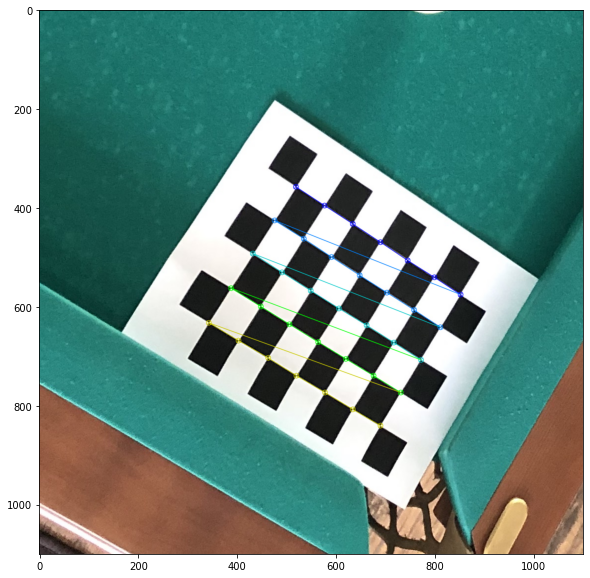

In [10]:
show_image(image=img_rgb_corners[2700:3800, 700:1800,], figsize=(10, 10)) # вывод изображения
# [2700:3800, 700:1800,] — срез пикселей (для приближения) по высоте от 2700 до 3800, по ширине от 700 до 1800, все 3 канала оставляем

## Получение "[вида сверху](https://digiratory.ru/1674)"

**Модель камеры:**

Матрицы ***P*** — проекционная матрица размерности *3x4*. Необходима для получения координат изображения в 2D из 3D проекции.

$$
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} 
= \mathbf{P} * \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} 
= \begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{bmatrix} * \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} 
$$

Она имеет 11 степеней свободы, то есть $p_{34}$ = 1

Или более точная запись:

$$
s * \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} 
= \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix} * \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_1 \\ r_{21} & r_{22} & r_{23} & t_2 \\ r_{31} & r_{32} & r_{33} & t_3 \end{bmatrix} * \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} 
$$

где 
$$
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} \text{— 2D Image coordinates} 
\newline
\begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix} \text{— Intrinsic properties (Optical centre, scaling)} 
\newline
\begin{bmatrix} r_{11} & r_{12} & r_{13} & t_1 \\ r_{21} & r_{22} & r_{23} & t_2 \\ r_{31} & r_{32} & r_{33} & t_3 \end{bmatrix} \text{— Extrinsic properties (Camera rotation, Translation)} 
\newline
\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} \text{— 3D World coordinates} 
$$

Откуда координаты изображения (пикселей) в 2D вычисляются следующим образом:
$$
x= \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
\newline
y= \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
$$

**Гомография:**

Работа с планарными (плоскими) объектами — часто возникающая задача в компьютерном зрении. 

Преобразования для планарных объектов называются **гомографией**. 

Два изображения одного и того же плоского объекта связаны **гомографией** — это преобразование ***H*** (матрица ***P*** в случае плоских изображений), отображающее точки одного изображения в точки другого изображения (***H*** трансформирует плоскость в плоскость).

$$
s * \begin{bmatrix} x^′ \\ y^′ \\ 1 \end{bmatrix} 
= \mathbf{H} * \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} 
= \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix} * \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

К примеру есть плоский объект, расположенный в одной плоскости, который имеет точки *q1, q2, q3, q4*. Мы снимаем объект в одном положении с фиксированной камерой, после чего снимаем этот же объект в другом положении с той же камеры. Точка *q1* представляет одну и ту же точку на двух разных изображениях, также как и точки *q2, q3 и q4*. В компьютерном зрении такие точки называются **соответствующими точками**.

Координаты точек на первом и втором изображении будут связаны преобразованием *гомографии*:
$$
x^′= \frac{h_{11}x + h_{12}y + h_{13}}{h_{31}x + h_{32}y + h_{33}}
\newline
y^′= \frac{h_{21}x + h_{22}y + h_{23}}{h_{31}x + h_{32}y + h_{33}}
$$

Выведем это преобразование:

Рассмотрим проекцию на первом изображении и проекцию на втором изображении. Во втором случае у нас другая проекционная матрица, потому что поза другая, соответственно точка тоже будет другая. Мы хотим ***найти преобразование между пикселями на изображении***. Идея получения этого преобразования состоит в следующем: ***так как объект плоский, то мы можем выбрать такую систему координат, в которой начало координат расположено где-то на этой плоскости***, ось ***Z*** будет направлена по нормали к этой плоскости (оси ***X***, ***Y*** будут направлены как-то на плоскости). ***В этой системе координат будут новые проекционные матрицы, которые всегда можно пересчитать***.

Главное, что координаты нашего объекта теперь вместо ***(X,Y,Z,1)*** будут ***(X,Y,0,1)***. При умножении такого вектора ***(X,Y,0,1)*** на проекционную матрицу размерности *3×4*, то третий столбец будет все время умножаться на ноль. Поэтому на плоскости в качестве проекционной матрицы мы можем использовать матрицу ***P*** без третьего столбца и умножать ее на вектор ***(X,Y,1)***. Если домножим ещё на обратную матрицу ***s***, то получим (*X*~*x*, *Y*~*y* при переходе от трёхмерного в двумерное пространство):

$$
s * \begin{bmatrix} x^′ \\ y^′ \\ 1 \end{bmatrix} 
= \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix} * \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
= s* \begin{bmatrix} p_{11} & p_{12} & — & p_{14} \\ p_{21} & p_{22} & — & p_{24} \\ p_{31} & p_{32} & — & p_{34} \end{bmatrix} * \begin{bmatrix} X \\ Y \\ — \\ 1 \end{bmatrix} 
$$

Таким образом, если мы знаем координаты первого изображения на плоскости, то существует такая матрица размером *3×3*, с помощью которой можно найти координаты на втором изображении, используя формулу приведенную выше. Результатом такого преобразования получается вектор в однородных координатах. Для перехода от однородных координат к мировым нужно результирующий вектор поделить на **s**.

**Из этого следует, что для получения "вида сверху" достаточно взять 4 точки из найденной шахматной доски, например — самые угловые. Затем вручную задать (так как нет других изображений) их поворот, чтобы они выровнялись (не были наклонены). По подсчитанным вручную положениям углов шахматной доски (выравнена поворотом) посчитать гомогенную матрицу, что необходима для поворота изначального изображения.**

In [11]:
corners_supporting = np.array([corners[i][0] for i in [0, 6, 28, 34]]) # оставляем 4 опорных угла (точки) в виде np.array (shape = (4,2) вместо (4,1,2))
# их номера 0, 6, 28, 34, так как всего углов 35 (нумеруются с 0) и они идут вдоль какой-нибудь стороны (вдоль столбцов по строкам)

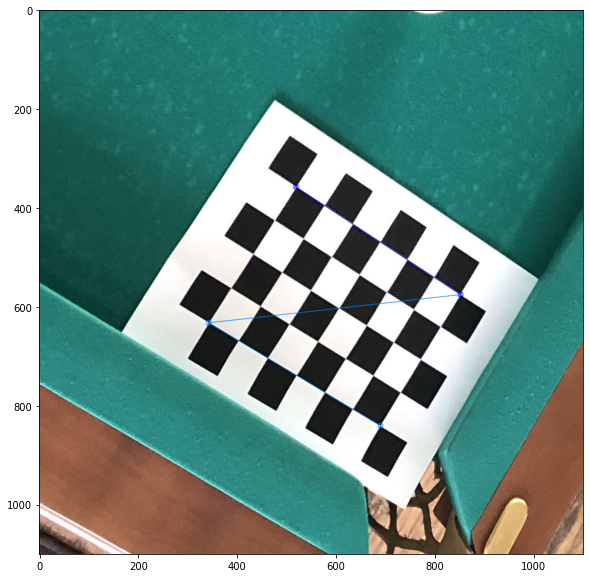

In [12]:
img_rgb_corners__supporting = img_rgb.copy() # делаем копию, чтобы не испортить оригинал
img_rgb_corners__supporting = cv2.drawChessboardCorners(image=img_rgb_corners__supporting, patternSize=(2, 2), corners=corners_supporting, patternWasFound=ret) # добавляем сетку найденной шахматной доски на изображение
# изменили patternSize на (2, 2), так как точек теперь 4

show_image(image=img_rgb_corners__supporting[2700:3800, 700:1800, :], figsize=(10, 10)) # вывод изображения
# [2700:3800, 700:1800, :] — срез пикселей (для приближения) по высоте от 2700 до 3800, по ширине от 700 до 1800, : — все 3 канала оставляем

Считаем расстояние между точками, чтобы узнать размер шахматной доски в писелях.

In [13]:
corners_supporting # координаты углов: сначала идёт ширина, а потом высота; однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([[1219.4376, 3056.5808],
       [1552.0151, 3275.3193],
       [1043.0817, 3331.5747],
       [1389.6381, 3540.387 ]], dtype=float32)

In [14]:
chess_height = cv2.norm(corners_supporting[0], corners_supporting[1]) # считаем норму (расстояние между точками) как высоту шахматной доски (точки 0 и 1)
chess_width = cv2.norm(corners_supporting[0], corners_supporting[2]) # считаем норму (расстояние между точками) как ширину шахматной доски (точка 0 и 2)

Задаём новую позицию для шахматной доски на изображении (пусть она будет в левом нижнем углу).

In [33]:
pad = 100 # размер отступа от края картинки (произвольный)
original_img_height = img_rgb.shape[0] # изначальная высота изображения (нужно так как ось OX идёт снизу вверх)

corners_new = np.array([[chess_width+pad, original_img_height - (chess_height+pad)], [chess_width+pad, original_img_height-pad], [pad, original_img_height - (chess_height+pad)], [pad, original_img_height-pad]], dtype=np.float32) # новое положение углов шахматной доски
corners_new # координаты новых углов: сначала идёт ширина, а потом высота; однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([[ 426.68497, 3533.9368 ],
       [ 426.68497, 3932.     ],
       [ 100.     , 3533.9368 ],
       [ 100.     , 3932.     ]], dtype=float32)

Трансформируем начальное изображение (получаем "вид сверху").

In [34]:
H = cv2.getPerspectiveTransform(corners_supporting, corners_new) # считаем матрицу гомографии
H

array([[ 4.10489753e-01, -7.00697079e-01,  1.98919603e+03],
       [ 2.78127675e-01,  3.55803712e-01,  1.45575204e+03],
       [-1.06244583e-04, -1.79258259e-05,  1.00000000e+00]])

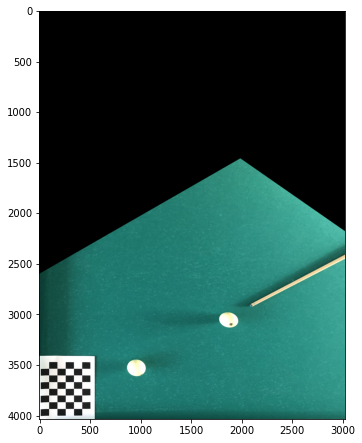

In [50]:
img_rgb_rotated = cv2.warpPerspective(img_rgb, H, dsize=(img_rgb.shape[1], img_rgb.shape[0])) # поворачиваем изначальное изображение с помощью гомографии
show_image(image=img_rgb_rotated, figsize=(10, 7.5)) # вывод изображения

Довольно большая часть (верх) картинки теперь не несёт информацию, поэтому обрежем её.

New shape: (2532, 3024, 3)


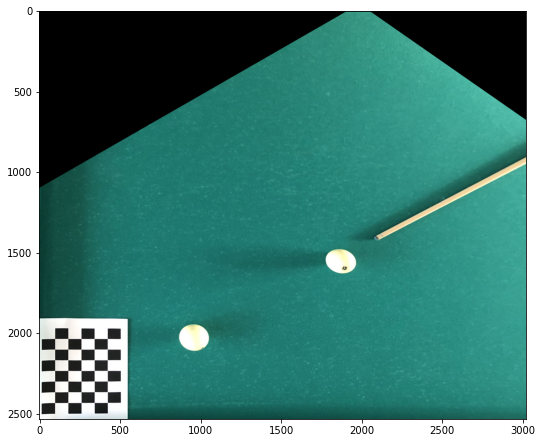

In [51]:
img_rgb_rotated = img_rgb_rotated[1500:, :, :] # [1500:, :, :] — срез пикселей по высоте от 1500 до низа изображения, по ширине и цветовым каналам всё остаётся как прежде
print(f"New shape: {img_rgb_rotated.shape}") # вывод размерности
show_image(image=img_rgb_rotated, figsize=(10, 7.5)) # вывод изображения

### Поиск шаров и кия

### Оценка направление удара и траектории прицельного шара после удара